In [57]:
import pandas as pd
import pandas_profiling

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

## データ修正

In [58]:
#データ読み込み
train = pd.read_csv("data/train_df.csv")
test = pd.read_csv("data/test_df.csv")
sample= pd.read_csv("data/submission.csv",header = None)

In [59]:
pd.options.display.max_columns = 100
random_state = 123
# train = train[:10000]
# test = test[:3000]
# train.info()

In [60]:
#カテゴリと考えられる変数を変更
train['id'] = train['id'].astype(object)
train['personal_id_1'] = train['personal_id_1'].astype(object)
train['personal_id_2'] = train['personal_id_2'].astype(object)                  
train['facility_id'] = train['facility_id'].astype(object) 
train['icu_5'] = train['icu_5'].astype(object)
train['icu_id'] = train['icu_id'].astype(object)


In [61]:
# 数値データ
x_train=train.drop('target_label',axis=1)
col_num = x_train.columns[x_train.dtypes!='object'].values.tolist()
print('数値データ')
print(col_num)
col_cat = x_train.columns[x_train.dtypes=='object'].values.tolist()
print('カテゴリ変数')
print(col_cat)

数値データ
['age', 'bmi', 'situation_1', 'situation_2', 'height', 'weight', 'icu_4', 'icu_6', 'icu_7', 'icu_8', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2', 'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate', 'blood_oxy', 'arterial_pressure', 'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma']
カテゴリ変数
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'ethnicity', 'gender', 'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_5', 'body_system_1', 'body_system_2']


In [62]:
"""
エンコーディングの方針
nunique が比較的少ない変数はLabel Encoding
nunique が多い変数はCount EncodingとTarget Encodingの併用
"""

low_cat_cols = [] # nunique が比較的少ない変数
high_cat_cols = [] # nunique が多い変数

for c in col_cat:
    nunq = x_train[c].nunique()
    if nunq>48:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)
        
body_systems = ['body_system_1', 'body_system_2']
for r in body_systems:
    low_cat_cols.remove(r)
        
print('-'*20, 'unique_low', '-'*20)
print(low_cat_cols)
print('-'*20, 'unique_high', '-'*20)
print(high_cat_cols)

print('-'*20, 'body_systems', '-'*20)
print(body_systems)

-------------------- unique_low --------------------
['ethnicity', 'gender', 'icu_1', 'icu_2', 'icu_3', 'icu_5']
-------------------- unique_high --------------------
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'icu_id']
-------------------- body_systems --------------------
['body_system_1', 'body_system_2']


In [63]:
#少ない要素は確認してみる
for c in low_cat_cols:
    print(f"{c}:\t{x_train[c].unique()}")

ethnicity:	['Caucasian' 'African American' 'Other/Unknown' 'Hispanic' nan 'Asian'
 'Native American']
gender:	['M' 'F' nan]
icu_1:	['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
icu_2:	['admit' 'readmit' 'transfer']
icu_3:	['MICU' 'CCU-CTICU' 'Med-Surg ICU' 'Neuro ICU' 'CSICU' 'SICU' 'CTICU'
 'Cardiac ICU']
icu_5:	[302.0 nan 304.0 123.0 114.0 305.0 301.0 122.0 119.0 308.0 113.0 118.0
 124.0 104.0 303.0 112.0 109.0 117.0 209.0 214.0 121.0 202.0 212.0 110.0
 101.0 116.0 217.0 102.0 115.0 203.0 105.0 103.0 108.0 307.0 213.0 120.0
 106.0 216.0 306.0 107.0 207.0 215.0 218.0 219.0 208.0]


In [64]:
#nunique が比較的少ない変数はLabel Encoding
#body_system1,2は同様のカラムだと考えohe

dict_low_cat = {}
for col in low_cat_cols:
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(x_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    # print(list_label)
    map_label = {j:i for i,j in enumerate(list_label)}
    train[col] = train[col].map(map_label)
    
    dict_low_cat[col] = {}
    dict_low_cat[col]['fillna'] = value_fillna
    dict_low_cat[col]['map_label'] = map_label
    dict_low_cat[col]['num_label'] = len(list_label)

print('Done')

ethnicity
gender
icu_1
icu_2
icu_3
icu_5
Done


In [65]:
# nunique が多い変数はCount EncodingとTarget Encodingの併用
# クロスバリデーション内で行う

# Count Encoding用
ids = ['id', 'personal_id_1', 'personal_id_2']
for i in ids:
    high_cat_cols.remove(i)
    
dict_high_cat = {}
for col in high_cat_cols :
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    
    map_count = x_train[col].value_counts().to_dict()
    x_train['CE_' + col] = x_train[col].map(map_count)
    
    dict_high_cat[col] = {}
    dict_high_cat[col]['fillna'] = value_fillna
    dict_high_cat[col]['map_count'] = map_count
    # dict_high_cat[col]['num_label'] = len(list_label)
    
    
print('Done')

facility_id
icu_id
Done


In [66]:
def transform_data(input_x):
    output_x = input_x.copy()
    
#     for col in col_num:
#         value_fillna = dict_num[col]['fillna']
#         output_x[col] = output_x[col].fillna(value_fillna)
        
#         value_mean = dict_num[col]['mean']
#         value_std = dict_num[col]['std']
#         output_x[col]  = (output_x[col] - value_mean ) / (value_std)
        
    for col in low_cat_cols:
        value_fillna = dict_low_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_label = dict_low_cat[col]['map_label']#辞書からlabelencordの辞書を取り出す
        output_x[col] = output_x[col].map(map_label)
        
        #対応するものがない場合はunkoumn
        output_x[col] = output_x[col].fillna(map_label['unknown'])
        
    for col in high_cat_cols:
        value_fillna = dict_high_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_count = dict_high_cat[col]['map_count']#辞書からcountencodeの辞書を取り出す
        output_x['CE_' + col] = output_x[col].map(map_count)
        
        
    return output_x

x_test = transform_data(test)

In [67]:
#body_sytemsとhigh_cat_cols（target_encord)以外修正後
#データを統合しbody_sytemsをone_hotencoding

# OHEのため全データ合算
concat_df = pd.concat([x_train, x_test], sort=False, ignore_index = True)


#病名のみのdf
train_body=concat_df[['body_system_1','body_system_2']]
#被っているものはbody_system_2をNanに
train_body['body_system_2'] = train_body['body_system_2'].where(
    train_body['body_system_1'] != train_body['body_system_2'])
#Nanはunknoun
train_body.fillna('unknown', inplace=True)

train_body['body_system_2'] = train_body['body_system_2'].replace('Undefined diagnoses', 'Undefined Diagnoses')
print(train_body.shape, concat_df.shape)

print(train_body['body_system_1'].unique())
print(train_body['body_system_2'].unique())
# ohe実行
ohe_body = pd.get_dummies(train_body.stack(), dummy_na=False, prefix='ohe').groupby(level=0).sum()

(64199, 2) (64199, 86)
['Cardiovascular' 'unknown' 'Gastrointestinal' 'Metabolic' 'Genitourinary'
 'Neurological' 'Trauma' 'Sepsis' 'Respiratory' 'Musculoskeletal/Skin'
 'Gynecological' 'Hematological']
['unknown' 'Renal/Genitourinary' 'Neurologic' 'Undefined Diagnoses'
 'Cardiovascular' 'Haematologic']


In [68]:
ohe_concat_df = pd.concat([concat_df, ohe_body], axis=1)#元の全体のDFに病歴のOHEをつなげる
ohe_concat_df = ohe_concat_df.drop(['body_system_1','body_system_2','ohe_unknown'], axis=1)
# 学習とテストに分解
n_train = ohe_concat_df[:len(x_train)]
n_train = pd.concat([n_train, train['target_label']], axis=1)
y_train = train[['target_label']]

n_test = ohe_concat_df[len(x_train):].reset_index(drop=True)

# Target Encoding用のラベル付きのDataFrameを用意
te_base_train = n_train[['facility_id', 'icu_id', 'target_label']].copy()
te_base_test = n_test[['facility_id', 'icu_id']].copy()

n_train.drop('target_label', axis=1, inplace=True)


print('学習用データ: {},   学習ラベル：{},  テストデータ：{}'.format(
    n_train.shape, y_train.shape, n_test.shape))
print('taget_encord用学習データ：{},  target_encord用テストデータ：{}'.format(
      te_base_train.shape, te_base_test.shape))

print('陽性ラベルの割合: {}％'.format(
    y_train.value_counts()[1] * 100 / len(n_train)))

学習用データ: (51359, 99),   学習ラベル：(51359, 1),  テストデータ：(12840, 99)
taget_encord用学習データ：(51359, 3),  target_encord用テストデータ：(12840, 2)
陽性ラベルの割合: 8.629451508012227％


def tranform_data_TE(cat_cols, input_x, train_label):#catslist, testdata(df), labels(series) =>df
    output_x = input_x.copy()
    
    for c in cat_cols :
        data_tmp = pd.DataFrame({c: output_x[c], 'target': train_label})
        target_mean = data_tmp.groupby(c)['target'].mean()
        output_x.loc[:, c] = output_x[c].map(target_mean)
        
    return  output_x


cat_cols = ['facility_id', 'icu_id']
n_test = tranform_data_TE(cat_cols, n_test, y_train['target_label'])

In [69]:
n_test

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,CE_facility_id,CE_icu_id,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
0,51359,12058,66446,83,37.0,NaN,0,0.0,2,1,182.9,NaN,95,1,1,5,0.902778,11,501.02,0,0.0,4.0,6.0,0.0,5.0,123.0,0.0,76.0,4.0,37.00,74.0,56.0,74.0,56.0,120.0,103.0,93.0,74.0,93.0,74.0,19.0,6.0,99.0,90.0,127.0,106.0,127.0,106.0,37.30,36.90,65.0,60.0,65.0,60.0,112.0,104.0,84.0,84.0,84.0,84.0,19.0,16.0,99.0,92.0,115.0,111.0,115.0,111.0,160.0,122.0,3.5,3.5,-1.00,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,451,451.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,51360,92348,32311,185,60.0,32.961764,1,0.0,2,1,185.4,113.30,679,2,0,6,0.406944,44,0.25,0,0.0,3.0,6.0,0.0,4.0,60.0,0.0,151.0,5.0,37.20,85.0,81.0,85.0,81.0,83.0,68.0,132.0,107.0,132.0,107.0,14.0,11.0,97.0,92.0,191.0,146.0,191.0,146.0,37.40,37.20,85.0,85.0,85.0,85.0,68.0,68.0,132.0,132.0,132.0,132.0,11.0,11.0,97.0,97.0,191.0,191.0,191.0,191.0,259.0,184.0,4.4,4.4,0.05,0.01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000,136.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,51361,68371,20639,157,70.0,19.295957,0,1.0,2,1,177.8,61.00,697,1,0,7,0.977083,38,211.09,0,0.0,3.0,5.0,0.0,1.0,106.0,0.0,58.0,39.0,36.50,78.0,51.0,78.0,51.0,87.0,69.0,98.0,73.0,98.0,73.0,20.0,14.0,100.0,100.0,127.0,103.0,127.0,103.0,36.60,36.50,78.0,78.0,78.0,78.0,87.0,87.0,98.0,98.0,98.0,98.0,14.0,14.0,100.0,100.0,127.0,127.0,127.0,127.0,113.0,93.0,4.1,4.1,0.13,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,751,350.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,51362,19544,116026,60,54.0,27.900747,0,1.0,2,1,180.3,90.70,538,0,0,5,0.172917,20,703.03,0,0.0,4.0,6.0,0.0,4.0,118.0,0.0,189.0,53.0,NaN,144.0,73.0,144.0,73.0,118.0,59.0,184.0,81.0,181.0,81.0,53.0,0.0,100.0,94.0,232.0,101.0,232.0,101.0,35.10,34.50,112.0,95.0,112.0,95.0,102.0,88.0,136.0,116.0,136.0,116.0,29.0,15.0,98.0,97.0,183.0,156.0,183.0,156.0,101.0,101.0,3.7,3.7,0.03,0.02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,320,320.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,51363,85588,102404,196,85.0,39.414062,0,1.0,2,0,160.0,100.90,809,0,0,1,0.031944,15,106.01,0,0.0,4.0,6.0,0.0,5.0,165.0,0.0,63.0,37.0,36.70,84.0,52.0,84.0,52.0,163.0,114.0,91.0,63.0,91.0,63.0,32.0,18.0,98.0,89.0,119.0,90.0,119.0,90.0,37.10,36.70,66.0,66.0,66.0,66.0,160.0,144.0,77.0,77.0,77.0,77.0,27.0,27.0,96.0,96.0,119.0,119.0,119.0,119.0,110.0,110.0,3.9,3.9,0.15,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1486,396.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12835,64194,79880,56511,19,39.0,23.147277,0,0.0,2,0,163.0,61.50,657,0,0,0,0.155556,39,301.01,0,0.0,4.0,6.0,0.0,5.0,113.0,0.0,62.0,8.0,36.33,98.0,52.0,98.0,52.0,111.0,84.0,106.0,62.0,106.0,62.0,21.0,10.0,97.0,88.0,159.0,85.0,159.0,85.0,37.38,36.33,63.0,54.0,63.0,54.0,103.0,100.0,75.0,68.0,75.0,68.0,17.0,15.0,94.0,90.0,120.0,109.0,120.0,109.0,117.0,89.0,6.4,5.5,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2227,465.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12836,64195,97405,32055,136,79.0,2

##　重み調整

In [70]:
from sklearn.utils.class_weight import compute_sample_weight
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
train_weight[:30]

array([0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       5.794111  , 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 5.794111  , 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 5.794111  , 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226],
      dtype=float32)

In [71]:
# カテゴリカル変数（ラベルエンコードとワンホットエンコードした特徴量）
# low_cat_colsは0,1、idsは三つのID、そのほかはOHEの出力0,1
cat_feats = low_cat_cols + ids + [c for c in n_train.columns if c.startswith('ohe_')]
for cat in cat_feats:
    # Category型に変換
    n_train[cat] = n_train[cat].astype('category')
    n_test[cat] = n_test[cat].astype('category')
    

N_FOLDS = 5
list_nfold=[0,1,2,3,4]
oof = np.zeros(len(n_train))
pred = np.zeros(len(n_test))
fi_df = pd.DataFrame()


# 必要に応じてencodeされた特徴量を保存し、あとで読み込めるようにしておく

# LightGBMのモデルの定義
random_state = 123
params = {
    'boosting_type' :'gbdt',
    'objective' : 'binary',
    'metrics' : 'auc',
    'learning_rate' : 0.1,
    'random_state' : random_state,
    'importance_type' : 'gain'
    }


In [80]:
n_train.columns

Index(['personal_id_1', 'personal_id_2', 'facility_id', 'age', 'bmi',
       'situation_1', 'situation_2', 'ethnicity', 'gender', 'height', 'weight',
       'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_4', 'icu_5', 'icu_6', 'icu_7',
       'icu_8', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2',
       'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate',
       'blood_oxy', 'arterial_pressure', 'respiratory_rate', 'temp',
       'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3',
       'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6',
       'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1',
       'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12',
       'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue',
       'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma',
       'CE_facility_id', 'CE_icu_id', 'ohe_Cardiovascular',
 

In [87]:
n_train.drop(['personal_id_1', 'personal_id_2', 'facility_id','icu_id'], axis=1)
id_train = train[['id']]
y_train = train[['target_label']]


n_test = test[[n_train.columns]]
id_test = test[[id_train.columns]]

KeyError: "None of [Index([('personal_id_1', 'personal_id_2', 'facility_id', 'age', 'bmi', 'situation_1', 'situation_2', 'ethnicity', 'gender', 'height', 'weight', 'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_4', 'icu_5', 'icu_6', 'icu_7', 'icu_8', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2', 'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate', 'blood_oxy', 'arterial_pressure', 'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma', 'CE_facility_id', 'CE_icu_id', 'ohe_Cardiovascular', 'ohe_Gastrointestinal', 'ohe_Genitourinary', 'ohe_Gynecological', 'ohe_Haematologic', 'ohe_Hematological', 'ohe_Metabolic', 'ohe_Musculoskeletal/Skin', 'ohe_Neurologic', 'ohe_Neurological', 'ohe_Renal/Genitourinary', 'ohe_Respiratory', 'ohe_Sepsis', 'ohe_Trauma', 'ohe_Undefined Diagnoses')], dtype='object')] are in the [columns]"

In [72]:
# cvでの評価用 iuput_yはsereis
def train_lgb(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
    print(input_x.shape)
    print(input_y.shape)
    
            
    cv = list(StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(n_train, y_train ))
    for  nfold in list_nfold :
        print('-'*20, nfold, '-'*20)
        # 変数をループしてtarget encoding
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        #CV内でCVしてtargetencording
        # x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
        train_weight = compute_sample_weight(class_weight='balanced', y=y_tr).astype('float32')
        
        # print(x_tr)
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
          format(y_train['target_label'].mean(), y_tr['target_label'].mean(), y_va['target_label'].mean(),))


        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr),(x_va,y_va)],
                  early_stopping_rounds=100,
                  verbose=100,
                  sample_weight = train_weight
                  
                 )
        # モデルの保存
        fname_lgb = 'model/lgb/model_lgb_fold{}.pickle'.format(nfold)
        with open(fname_lgb, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        print('[auc] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # imp
        _imp = pd.DataFrame({'col':input_x.columns, 'imp':model.feature_importances_,'nfold':nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=False)

    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        roc_auc_score(input_y, train_oof)))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
    # imp出力
    imp = imp.groupby('col')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    imp.columns = ['col', 'imp', 'imp_std']

    print('Done')
    
    return train_oof, imp, metrics

In [73]:
id_train = n_train[['id']]
n_train = n_train.drop(['id'], axis=1)

In [74]:
train_oof, imp, metrics = train_lgb(n_train, y_train, id_train, params,list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

(51359, 98)
(51359, 1)
-------------------- 0 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: facility_id, icu_id

In [24]:
imp.sort_values('imp', ascending=False)[:30]

,col,imp,imp_std
96,x5,62574.084443,7121.385684
28,icu_5,21806.314151,1133.364213
97,x6,13875.056828,7355.532237
59,v12,6139.192390,991.547324
57,v10,5880.893269,547.386781
65,v2,4341.390004,408.773490
2,age,3967.040409,486.273704
64,v1_heartrate_max,2945.903567,175.966839
71,v8,2871.795071,234.575880
27,icu_4,2489.834468,202.423160


In [25]:
train_oof

,id,pred
0,0,0.718880
1,1,0.629117
2,2,0.328673
3,3,0.006618
4,4,0.103982
...,...,...
51354,51354,0.106811
51355,51355,0.520702
51356,51356,0.345277
51357,51357,0.028387


## 推論

In [26]:
def predict_lgb(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_lgb = 'model/lgb/model_lgb_fold{}.pickle'.format(nfold)
        with open(fname_lgb, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = model.predict_proba(input_x)[:,1]
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'target_label':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [27]:
id_test = test[id_train.columns]
n_test = n_test.drop(['id'], axis=1)


In [28]:
test_pred_proba = predict_lgb(
    n_test,
    id_test,
    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


In [29]:
test_pred_proba[:20]

,id,target_label
0,51359,0.605820
1,51360,0.633235
2,51361,0.623139
3,51362,0.522248
4,51363,0.594972
5,51364,0.528131
6,51365,0.624151
7,51366,0.546934
8,51367,0.566277
9,51368,0.553191


In [30]:
test_pred_proba.to_csv('sub/submission_lgb.csv', index=None, header=True,)

In [31]:
sample= pd.read_csv("data/submission.csv",header = None)
sample

,0,1
0,id,target_label
1,51359,0.5
2,51360,0.5
3,51361,0.5
4,51362,0.5
...,...,...
12836,64194,0.5
12837,64195,0.5
12838,64196,0.5
12839,64197,0.5


## ベースライン

In [32]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(n_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (41087, 98) (41087, 1)
ベースライン検証データ:  (10272, 98) (10272, 1)
検証データ(train):  (32869, 98) (32869, 1)
検証データ(test):  (8218, 98) (8218, 1)


In [33]:
x_tr1, x_va1 = target_encoding(cat_cols, x_tr1, y_tr1, x_va1)
cat_cols = ['facility_id', 'icu_id']
x_va1 = tranform_data_TE(cat_cols, x_va1, y_tr1['target_label'])
x_va2 = tranform_data_TE(cat_cols, x_va2, y_tr['target_label'])




model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1),(x_va1,y_va1)],
          early_stopping_rounds=100,
          verbose=10,
         )

[10]	training's auc: 0.895905	valid_1's auc: 0.87288
[20]	training's auc: 0.916271	valid_1's auc: 0.87631
[30]	training's auc: 0.931062	valid_1's auc: 0.880703
[40]	training's auc: 0.941808	valid_1's auc: 0.883026
[50]	training's auc: 0.950745	valid_1's auc: 0.884641
[60]	training's auc: 0.958398	valid_1's auc: 0.885369
[70]	training's auc: 0.965192	valid_1's auc: 0.883709
[80]	training's auc: 0.970629	valid_1's auc: 0.881337
[90]	training's auc: 0.975208	valid_1's auc: 0.880694
[100]	training's auc: 0.979234	valid_1's auc: 0.881226


LGBMClassifier(importance_type='gain', metrics='auc', objective='binary',
               random_state=123)

[検証データ] auc: 0.8812
[ベースライン検証データ] auc: 0.8780


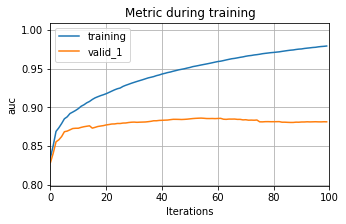

In [34]:
#評価指標の差
y_va1_pred_proba = model.predict_proba(x_va1)
y_va2_pred_proba = model.predict_proba(x_va2)
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred_proba[:,1])))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred_proba[:,1])))

ax = lgb.plot_metric(model.evals_result_, metric='auc', figsize=(5, 3))

In [35]:
#誤分類の分布
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[7451   58]
 [ 535  174]]
[[0.90666829 0.00705768]
 [0.065101   0.02117303]]
ベースライン検証データ
[[9307   79]
 [ 655  231]]
[[0.9060553  0.00769081]
 [0.06376558 0.02248832]]


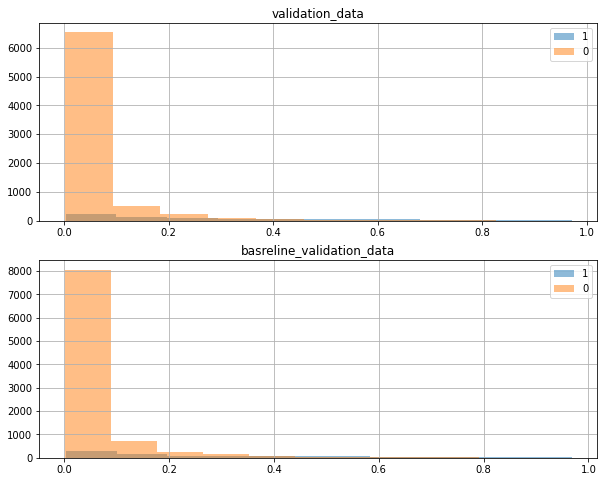

In [36]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

## チューニング

In [85]:
import optuna

In [30]:
# 探索するパラメータ

params_base = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': 0.02,
    'n_estimators': 100000,
    'bagging_freq': 1,
    'seed': 123,
}
random_state=123

def objective(trial):
    # 探索するパラメータ
    params_tuning = {
        'num_leaves': trial.suggest_int('num_leaves',8,256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',5,200),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-5, 1e-2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e2, log=True),
    }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state).split(n_train, y_train))
    for nfold in np.arange(4):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = n_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = n_train.loc[idx_va, :], y_train.loc[idx_va, :]
        cat_cols = ['facility_id', 'icu_id']
        x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
    
        model = lgb.LGBMClassifier(**params_tuning)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr, y_tr), (x_va, y_va)],
                  early_stopping_rounds=100,
                  verbose=0,
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>0.5, 1, 0))
        list_metrics.append(metric_va)
        
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

In [31]:
sampler = optuna.samplers.TPESampler(seed=random_state)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-03-26 17:02:05,054] A new study created in memory with name: no-name-6a4964f3-693a-4e1d-be5a-e3f9c6ba7d9d


[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597344848927815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.792414358623587e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.792414358623587e-05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.7756573845414456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756573845414456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597344848927815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.792414358623587e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-26 17:02:34,357] Trial 0 finished with value: 0.9292042471718399 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.792414358623587e-05, 'feature_fraction': 0.7756573845414456, 'bagging_fraction': 0.8597344848927815, 'reg_alpha': 0.492522233779106, 'reg_lambda': 83.76388146302445}. Best is trial 0 with value: 0.9292042471718399.


[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015009027543233888
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessi

[I 2023-03-26 17:02:53,020] Trial 1 finished with value: 0.9297883593213726 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 99, 'min_sum_hessian_in_leaf': 0.00015009027543233888, 'feature_fraction': 0.6715890080754348, 'bagging_fraction': 0.8645248536920208, 'reg_alpha': 0.567922374174008, 'reg_lambda': 0.01732652966363563}. Best is trial 1 with value: 0.9297883593213726.


[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.52756635172055e-05
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_i

[I 2023-03-26 17:03:07,178] Trial 2 finished with value: 0.9296131196104935 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 149, 'min_sum_hessian_in_leaf': 3.52756635172055e-05, 'feature_fraction': 0.5877258780737462, 'bagging_fraction': 0.7657756869209191, 'reg_alpha': 1.3406343673102123, 'reg_lambda': 3.4482904089131434}. Best is trial 1 with value: 0.9297883593213726.


[LightGBM] [Warning] bagging_fraction is set=0.6614794569265892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614794569265892
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006808799287054756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0006808799287054756
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] feature_fraction is set=0.8612216912851107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8612216912851107
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6614794569265892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614794569265892
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006808799287054756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-26 17:03:20,954] Trial 3 finished with value: 0.9298857189288187 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 146, 'min_sum_hessian_in_leaf': 0.0006808799287054756, 'feature_fraction': 0.8612216912851107, 'bagging_fraction': 0.6614794569265892, 'reg_alpha': 0.2799978022399009, 'reg_lambda': 0.08185645330667264}. Best is trial 3 with value: 0.9298857189288187.


[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313816648219
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.889360449174926e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.889360449174926e-05
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] feature_fraction is set=0.7168505863397641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168505863397641
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313816648219
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.889360449174926e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-26 17:03:33,151] Trial 4 finished with value: 0.9298078266933474 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 128, 'min_sum_hessian_in_leaf': 1.889360449174926e-05, 'feature_fraction': 0.7168505863397641, 'bagging_fraction': 0.7154313816648219, 'reg_alpha': 0.9434967110751797, 'reg_lambda': 0.5050346330980694}. Best is trial 3 with value: 0.9298857189288187.


[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509183379421682
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004788147156768277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.004788147156768277
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.9720800091019398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720800091019398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509183379421682
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004788147156768277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

[I 2023-03-26 17:03:46,123] Trial 5 finished with value: 0.9299051787182695 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 88, 'min_sum_hessian_in_leaf': 0.004788147156768277, 'feature_fraction': 0.9720800091019398, 'bagging_fraction': 0.7509183379421682, 'reg_alpha': 3.1319282717196035, 'reg_lambda': 0.029005047452739414}. Best is trial 5 with value: 0.9299051787182695.


[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415171321313522
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003971252247766701, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.003971252247766701
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.6252276826982534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252276826982534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415171321313522
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003971252247766701, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

[I 2023-03-26 17:04:38,671] Trial 6 finished with value: 0.9249401572045259 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 86, 'min_sum_hessian_in_leaf': 0.003971252247766701, 'feature_fraction': 0.6252276826982534, 'bagging_fraction': 0.7415171321313522, 'reg_alpha': 87.54657140659076, 'reg_lambda': 1.1965765212602313}. Best is trial 5 with value: 0.9299051787182695.


[LightGBM] [Warning] bagging_fraction is set=0.7725340032332324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725340032332324
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0030131614432849746, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0030131614432849746
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.8015300642054637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8015300642054637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7725340032332324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725340032332324
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0030131614432849746, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-26 17:05:06,028] Trial 7 finished with value: 0.9303724911854675 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0030131614432849746, 'feature_fraction': 0.8015300642054637, 'bagging_fraction': 0.7725340032332324, 'reg_alpha': 0.23499322154972468, 'reg_lambda': 0.1646202117975735}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346568914811361
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00423029374725911, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00423029374725911
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] feature_fraction is set=0.7552111687390055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552111687390055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346568914811361
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00423029374725911, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_l

[I 2023-03-26 17:05:24,450] Trial 8 finished with value: 0.9299441255942575 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 138, 'min_sum_hessian_in_leaf': 0.00423029374725911, 'feature_fraction': 0.7552111687390055, 'bagging_fraction': 0.8346568914811361, 'reg_alpha': 2.206714812711709, 'reg_lambda': 3.1594683442464033}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218331872684371
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7765808030254076e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7765808030254076e-05
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] feature_fraction is set=0.8818414207216692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818414207216692
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218331872684371
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7765808030254076e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hes

[I 2023-03-26 17:05:38,297] Trial 9 finished with value: 0.9296910133624697 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 170, 'min_sum_hessian_in_leaf': 1.7765808030254076e-05, 'feature_fraction': 0.8818414207216692, 'bagging_fraction': 0.6218331872684371, 'reg_alpha': 0.05982625838323253, 'reg_lambda': 1.9490717640641542}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940542446575642
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0010167214653943027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0010167214653943027
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.5040305717020102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5040305717020102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940542446575642
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0010167214653943027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in

[I 2023-03-26 17:05:54,892] Trial 10 finished with value: 0.9299635808341942 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 0.0010167214653943027, 'feature_fraction': 0.5040305717020102, 'bagging_fraction': 0.9940542446575642, 'reg_alpha': 0.010612397212799423, 'reg_lambda': 0.1661409929489422}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.9816139361200471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9816139361200471
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.000991454198994495, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.000991454198994495
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.552457608315914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.552457608315914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9816139361200471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9816139361200471
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.000991454198994495, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf

[I 2023-03-26 17:06:10,701] Trial 11 finished with value: 0.9300998933836474 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 0.000991454198994495, 'feature_fraction': 0.552457608315914, 'bagging_fraction': 0.9816139361200471, 'reg_alpha': 0.011325252532212334, 'reg_lambda': 0.11400599767507363}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.5595408581248553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595408581248553
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0011772429116239105, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0011772429116239105
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.5082312939353781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5082312939353781
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5595408581248553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595408581248553
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0011772429116239105, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-26 17:06:33,992] Trial 12 finished with value: 0.9302751270285072 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 0.0011772429116239105, 'feature_fraction': 0.5082312939353781, 'bagging_fraction': 0.5595408581248553, 'reg_alpha': 0.01159602699379102, 'reg_lambda': 0.01036230661502322}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.5011737451921937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5011737451921937
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00964425200568059, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00964425200568059
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.5018388179694604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5018388179694604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5011737451921937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5011737451921937
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00964425200568059, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_lea

[I 2023-03-26 17:06:51,973] Trial 13 finished with value: 0.9302167355281161 and parameters: {'num_leaves': 8, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 0.00964425200568059, 'feature_fraction': 0.5018388179694604, 'bagging_fraction': 0.5011737451921937, 'reg_alpha': 0.049404029796241616, 'reg_lambda': 0.010741655892621712}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.5702475504683538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5702475504683538
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0017038597330333353, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0017038597330333353
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.6396458301362229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6396458301362229
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5702475504683538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5702475504683538
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0017038597330333353, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-26 17:07:12,513] Trial 14 finished with value: 0.9300414943007324 and parameters: {'num_leaves': 252, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.0017038597330333353, 'feature_fraction': 0.6396458301362229, 'bagging_fraction': 0.5702475504683538, 'reg_alpha': 0.06618100230922958, 'reg_lambda': 0.02945708758420021}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.5024707401359401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5024707401359401
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00033040787452620027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00033040787452620027
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.690460596426745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.690460596426745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5024707401359401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5024707401359401
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00033040787452620027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian

[I 2023-03-26 17:07:27,847] Trial 15 finished with value: 0.9290484642174022 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.00033040787452620027, 'feature_fraction': 0.690460596426745, 'bagging_fraction': 0.5024707401359401, 'reg_alpha': 0.13370881018814096, 'reg_lambda': 0.043977290456925416}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.6452398944350926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6452398944350926
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0021159525252302494, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0021159525252302494
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.7970553508142445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7970553508142445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6452398944350926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6452398944350926
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0021159525252302494, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-26 17:07:41,885] Trial 16 finished with value: 0.9299246673213115 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 65, 'min_sum_hessian_in_leaf': 0.0021159525252302494, 'feature_fraction': 0.7970553508142445, 'bagging_fraction': 0.6452398944350926, 'reg_alpha': 0.019334078224433136, 'reg_lambda': 0.01033528363848504}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.5752171935407671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752171935407671
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00041942600526778174, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00041942600526778174
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.5869412794303933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5869412794303933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5752171935407671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752171935407671
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00041942600526778174, min_child_weight=0.001 will be ignored. Current value: min_sum_hessi

[I 2023-03-26 17:08:02,806] Trial 17 finished with value: 0.9297883669038965 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.00041942600526778174, 'feature_fraction': 0.5869412794303933, 'bagging_fraction': 0.5752171935407671, 'reg_alpha': 0.025311724004931247, 'reg_lambda': 0.33628795681597595}. Best is trial 7 with value: 0.9303724911854675.


[LightGBM] [Warning] bagging_fraction is set=0.693885320471026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.693885320471026
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00017334697738671855, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00017334697738671855
[LightGBM] [Warning] min_data_in_leaf is set=192, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=192
[LightGBM] [Warning] feature_fraction is set=0.7170673281924885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7170673281924885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.693885320471026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.693885320471026
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00017334697738671855, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian

[I 2023-03-26 17:08:14,271] Trial 18 finished with value: 0.9305282635243717 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 192, 'min_sum_hessian_in_leaf': 0.00017334697738671855, 'feature_fraction': 0.7170673281924885, 'bagging_fraction': 0.693885320471026, 'reg_alpha': 0.1772628567955448, 'reg_lambda': 0.05472030768993216}. Best is trial 18 with value: 0.9305282635243717.


[LightGBM] [Warning] bagging_fraction is set=0.6727788490264094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6727788490264094
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001512831384976337, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0001512831384976337
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.7265378117746244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7265378117746244
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6727788490264094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6727788490264094
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001512831384976337, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-26 17:08:27,904] Trial 19 finished with value: 0.9293210635357272 and parameters: {'num_leaves': 49, 'min_data_in_leaf': 200, 'min_sum_hessian_in_leaf': 0.0001512831384976337, 'feature_fraction': 0.7265378117746244, 'bagging_fraction': 0.6727788490264094, 'reg_alpha': 0.1901921923183269, 'reg_lambda': 0.05322539089196862}. Best is trial 18 with value: 0.9305282635243717.


[LightGBM] [Warning] bagging_fraction is set=0.7938749424483875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938749424483875
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001745939889031575, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0001745939889031575
[LightGBM] [Warning] min_data_in_leaf is set=194, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=194
[LightGBM] [Warning] feature_fraction is set=0.8021429800461279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8021429800461279
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7938749424483875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938749424483875
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0001745939889031575, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-26 17:08:43,915] Trial 20 finished with value: 0.9298857219618283 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 194, 'min_sum_hessian_in_leaf': 0.0001745939889031575, 'feature_fraction': 0.8021429800461279, 'bagging_fraction': 0.7938749424483875, 'reg_alpha': 0.15470937382525465, 'reg_lambda': 0.20155916582751363}. Best is trial 18 with value: 0.9305282635243717.


[LightGBM] [Warning] bagging_fraction is set=0.6940449441275507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6940449441275507
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006336965286253373, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0006336965286253373
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.6763043207576405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6763043207576405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6940449441275507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6940449441275507
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006336965286253373, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_

[I 2023-03-26 17:09:01,071] Trial 21 finished with value: 0.9295936522385186 and parameters: {'num_leaves': 8, 'min_data_in_leaf': 63, 'min_sum_hessian_in_leaf': 0.0006336965286253373, 'feature_fraction': 0.6763043207576405, 'bagging_fraction': 0.6940449441275507, 'reg_alpha': 0.03842488453148413, 'reg_lambda': 0.058564740968220945}. Best is trial 18 with value: 0.9305282635243717.


[LightGBM] [Warning] bagging_fraction is set=0.7045329194506366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7045329194506366
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001830751538863638, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001830751538863638
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.7259183848653861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7259183848653861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7045329194506366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7045329194506366
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001830751538863638, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_

[I 2023-03-26 17:09:14,537] Trial 22 finished with value: 0.9299246521562635 and parameters: {'num_leaves': 39, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 0.001830751538863638, 'feature_fraction': 0.7259183848653861, 'bagging_fraction': 0.7045329194506366, 'reg_alpha': 0.11311814251672293, 'reg_lambda': 0.022441717547825354}. Best is trial 18 with value: 0.9305282635243717.


[LightGBM] [Warning] bagging_fraction is set=0.6169712716037121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6169712716037121
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0003247960568681629, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0003247960568681629
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] feature_fraction is set=0.6460527266501457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6460527266501457
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6169712716037121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6169712716037121
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0003247960568681629, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-26 17:09:30,134] Trial 23 finished with value: 0.9306450905037926 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 113, 'min_sum_hessian_in_leaf': 0.0003247960568681629, 'feature_fraction': 0.6460527266501457, 'bagging_fraction': 0.6169712716037121, 'reg_alpha': 0.028105310658606258, 'reg_lambda': 0.10619688398329478}. Best is trial 23 with value: 0.9306450905037926.


[LightGBM] [Warning] bagging_fraction is set=0.623545387976872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.623545387976872
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00022348870192262981, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00022348870192262981
[LightGBM] [Warning] min_data_in_leaf is set=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] feature_fraction is set=0.6587768585473897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6587768585473897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.623545387976872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.623545387976872
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00022348870192262981, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian

[I 2023-03-26 17:09:43,121] Trial 24 finished with value: 0.929710491349978 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 172, 'min_sum_hessian_in_leaf': 0.00022348870192262981, 'feature_fraction': 0.6587768585473897, 'bagging_fraction': 0.623545387976872, 'reg_alpha': 0.08719667988379043, 'reg_lambda': 0.09736915167388008}. Best is trial 23 with value: 0.9306450905037926.


[LightGBM] [Warning] bagging_fraction is set=0.706090260541778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.706090260541778
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9.105799384867685e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9.105799384867685e-05
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] feature_fraction is set=0.7094962388840546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7094962388840546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.706090260541778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.706090260541778
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9.105799384867685e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in

[I 2023-03-26 17:09:58,683] Trial 25 finished with value: 0.9295741863830488 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 116, 'min_sum_hessian_in_leaf': 9.105799384867685e-05, 'feature_fraction': 0.7094962388840546, 'bagging_fraction': 0.706090260541778, 'reg_alpha': 0.31491796599336036, 'reg_lambda': 0.3287048364174787}. Best is trial 23 with value: 0.9306450905037926.


[LightGBM] [Warning] bagging_fraction is set=0.6224015290254946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224015290254946
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0004570599250071687, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0004570599250071687
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.7561269779942515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7561269779942515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6224015290254946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6224015290254946
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0004570599250071687, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-26 17:10:13,855] Trial 26 finished with value: 0.9300414882347132 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 168, 'min_sum_hessian_in_leaf': 0.0004570599250071687, 'feature_fraction': 0.7561269779942515, 'bagging_fraction': 0.6224015290254946, 'reg_alpha': 0.030076610853130133, 'reg_lambda': 0.14303725244157842}. Best is trial 23 with value: 0.9306450905037926.


[LightGBM] [Warning] bagging_fraction is set=0.7749517883796162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749517883796162
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00030279503155269586, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00030279503155269586
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] feature_fraction is set=0.6249312811581513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6249312811581513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7749517883796162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7749517883796162
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00030279503155269586, min_child_weight=0.001 will be ignored. Current value: min_sum_hes

[I 2023-03-26 17:10:27,786] Trial 27 finished with value: 0.9306450783717544 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 111, 'min_sum_hessian_in_leaf': 0.00030279503155269586, 'feature_fraction': 0.6249312811581513, 'bagging_fraction': 0.7749517883796162, 'reg_alpha': 0.0696257604575403, 'reg_lambda': 0.05649986721895862}. Best is trial 23 with value: 0.9306450905037926.


[LightGBM] [Warning] bagging_fraction is set=0.6746005577540128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6746005577540128
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002836428386674045, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002836428386674045
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] feature_fraction is set=0.6245784772581751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6245784772581751
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6746005577540128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6746005577540128
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002836428386674045, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-26 17:10:42,724] Trial 28 finished with value: 0.9300609586396976 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 115, 'min_sum_hessian_in_leaf': 0.0002836428386674045, 'feature_fraction': 0.6245784772581751, 'bagging_fraction': 0.6746005577540128, 'reg_alpha': 0.07446361968017055, 'reg_lambda': 0.0461531952556658}. Best is trial 23 with value: 0.9306450905037926.


[LightGBM] [Warning] bagging_fraction is set=0.7233344932111209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7233344932111209
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.839185136974349e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.839185136974349e-05
[LightGBM] [Warning] min_data_in_leaf is set=186, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=186
[LightGBM] [Warning] feature_fraction is set=0.6408046006113458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6408046006113458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7233344932111209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7233344932111209
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.839185136974349e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessia

[I 2023-03-26 17:10:55,914] Trial 29 finished with value: 0.9301193789536797 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 186, 'min_sum_hessian_in_leaf': 6.839185136974349e-05, 'feature_fraction': 0.6408046006113458, 'bagging_fraction': 0.7233344932111209, 'reg_alpha': 0.02530221552624873, 'reg_lambda': 0.07285277672848327}. Best is trial 23 with value: 0.9306450905037926.


In [32]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

acc(best)=0.9306


{'num_leaves': 119,
 'min_data_in_leaf': 113,
 'min_sum_hessian_in_leaf': 0.0003247960568681629,
 'feature_fraction': 0.6460527266501457,
 'bagging_fraction': 0.6169712716037121,
 'reg_alpha': 0.028105310658606258,
 'reg_lambda': 0.10619688398329478}

In [33]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 119,
 'min_data_in_leaf': 113,
 'min_sum_hessian_in_leaf': 0.0003247960568681629,
 'feature_fraction': 0.6460527266501457,
 'bagging_fraction': 0.6169712716037121,
 'reg_alpha': 0.028105310658606258,
 'reg_lambda': 0.10619688398329478,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metrics': 'auc',
 'learning_rate': 0.02,
 'n_estimators': 100000,
 'bagging_freq': 1,
 'seed': 123}

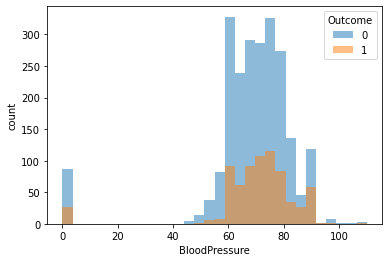

In [153]:
#　血圧との関係
plt.hist(train.loc[train['Outcome'] == 0, 'BloodPressure'].dropna(),
         bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Outcome'] == 1, 'BloodPressure'].dropna(),
         bins=30, alpha=0.5, label='1')
plt.xlabel('BloodPressure')
plt.ylabel('count')
plt.legend(title='Outcome')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   int64  
 10  BloodPressure_new         2887 non-null   float64
dtypes: float64(3), int64(8)
memory usage: 257.9 KB
70.97859744990893
72.88277858176556
71.43436092829927
87
26


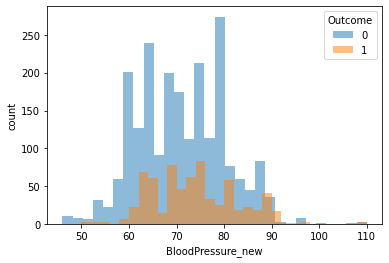

In [154]:
train['BloodPressure_new'] = train['BloodPressure'].replace([0], np.nan)
plt.hist(train.loc[train['Outcome'] == 0, 'BloodPressure_new'].dropna(),
         bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Outcome'] == 1, 'BloodPressure_new'].dropna(),
         bins=30, alpha=0.5, label='1')
plt.xlabel('BloodPressure_new')
plt.ylabel('count')
plt.legend(title='Outcome')

train.info()
BPmean_0= train.loc[train['Outcome'] == 0, 'BloodPressure_new'].mean()
print(BPmean_0)
BPmean_1= train.loc[train['Outcome'] == 1, 'BloodPressure_new'].mean()
print(BPmean_1)
BPmean= train['BloodPressure_new'].mean()
print(BPmean)

print(train[train['Outcome']==0]['BloodPressure_new'].isnull().sum(axis=0))
print(train[train['Outcome']==1]['BloodPressure_new'].isnull().sum(axis=0))

血圧0は欠損、欠損かどうかの特徴量作成(0なら1、取得された値があれば1)

## 欠損処理関数

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample= pd.read_csv("data/sample_submit.csv",header = None)

In [195]:
#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'Pregnancies_bin'
                ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [196]:
# 数値データ
col_num = X_train.columns[X_train.dtypes!='object'].values.tolist()

dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    X_train[col] = X_train[col].fillna(value_fillna)
    # 正規化
    value_min = X_train[col].min()
    value_max = X_train[col].max()
    value_mean = X_train[col].mean()
    value_std = X_train[col].std()
    X_train[col] = (X_train[col] - value_min) / (value_max - value_min)
    # X_tarin[col] = (X_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_max    
    dict_num[col]['std'] = value_max    
    
print('Done')

DiabetesPedigreeFunction
BMI
Glucose
Age
Pregnancies
Done


In [197]:
# カテゴリデータ
# （embedding予定でラベルエンコーダー）
from sklearn.preprocessing import LabelEncoder
col_cat = X_train.columns[X_train.dtypes=='object'].values.tolist()

dict_cat = {}
for col in col_cat:
    print(col)
    value_fillna = 'unknown'
    X_train[col] = X_train[col].fillna(value_fillna)
    
    X_train[col] = X_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(X_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    map_label = {j:i for i,j in enumerate(list_label)}
    X_train[col] = X_train[col].map(map_label)
    
    dict_cat[col] = {}
    dict_cat[col]['fillna'] = value_fillna
    dict_cat[col]['map_label'] = map_label
    dict_cat[col]['num_label'] = len(list_label)

print('Done')


Pregnancies_bin
Done


In [199]:
X_test

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,Pregnancies_bin
0,0.313823,0.708574,0.496403,0.000000,0.000000,2
1,0.027125,0.702316,0.223022,0.021739,0.230769,1
2,0.173992,0.557487,0.410072,0.000000,0.230769,1
3,0.166544,0.419302,0.640288,0.369565,0.076923,0
4,0.303618,0.712381,0.474820,0.152174,0.076923,0
...,...,...,...,...,...,...
1995,0.013546,0.693011,0.669065,0.108696,0.307692,1
1996,0.168592,0.676110,0.690647,0.152174,0.461538,3
1997,0.270176,0.962270,0.352518,0.173913,0.538462,3
1998,0.079172,0.712423,0.316547,0.108696,0.153846,0


In [200]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DiabetesPedigreeFunction  3000 non-null   float64
 1   BMI                       3000 non-null   float64
 2   Glucose                   3000 non-null   float64
 3   Age                       3000 non-null   float64
 4   Pregnancies               3000 non-null   float64
 5   Pregnancies_bin           3000 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.8 KB


In [173]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(X_train['Pregnancies_bin'].values.reshape(-1, 1))
list_ohe_label = sorted(list(set(le.classes_) | set(['unknown'])))
map_ohe_label = {j:i for i,j in enumerate(list_label)}

map_label

{'-1': 0, '-3': 1, '0': 2, '3-': 3, 'unknown': 4}